# Data Preparation


saved `.h5` dataset will be standarlized and normalzied between (0, 1)

In [1]:
import os 
import json

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms


from module.transforms import Standardize, Normalize, RandomFlip, RandomRotate, RandomRotate90, ElasticDeformation, AdditiveGaussianNoise, AdditivePoissonNoise, ToTensor
from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, display_4d_image
from module.datasets import load_4d_dicom, save_4d_dicom

from tqdm.notebook import tqdm
import h5py


In [4]:
#
data_dir = "./dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM"

#
slices_np = load_4d_dicom(data_dir)
print(f"Loaded...{os.path.basename(data_dir)} {slices_np.dtype} (shape:{slices_np.shape}; range:[{np.min(slices_np)},{np.max(slices_np)}]; mean:{np.mean(slices_np)}; std:{np.std(slices_np)})")
display_4d_image(slices_np)

Loaded...PT_20p 150_120 OSEM int16 (shape:(24, 71, 192, 192); range:[-32767,32767]; mean:201.12048776036573; std:1412.4139804758772)


interactive(children=(IntSlider(value=0, description='Time', max=23), IntSlider(value=0, description='Slice', …

## Option 1: Real-world Noise Dataset

In [5]:
#
norm_slices = (slices_np - np.mean(slices_np)) / np.std(slices_np)

min_val = np.min(norm_slices)
max_val = np.max(norm_slices)

norm_slices = (norm_slices - np.min(norm_slices)) / (np.max(norm_slices) - np.min(norm_slices))


# nessary info for restored 
restore_info = {'mean': np.mean(slices_np).item(),
             'std': np.std(slices_np).item(),
             'min': min_val.item(),
             'max': max_val.item()}


print(restore_info)


# save real noise dataset
file_name = f"{os.path.basename(data_dir)}_real"
with h5py.File(f'./dataset/preprocessed/{file_name}.h5', 'w') as f:
    f.create_dataset('dataset', data=norm_slices)
    f.create_dataset('restore_info', data=np.array(json.dumps(restore_info), dtype=h5py.string_dtype()))

{'mean': 201.12048776036573, 'std': 1412.4139804758772, 'min': -23.34168377224119, 'max': 23.05689405684542}


## Option 2: Synthetic Noise Dataset

### 2.1 Prepare gaussian nosie dataset

Text(0.5, 1.0, 'diff')

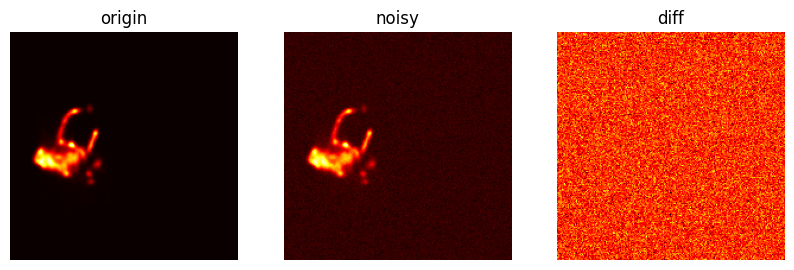

In [6]:
# demostrate
norm_slices = (slices_np - np.mean(slices_np)) / np.std(slices_np)
norm_slices = (norm_slices - np.min(norm_slices)) / (np.max(norm_slices) - np.min(norm_slices))

#
rs = np.random.RandomState(seed=80)


clean_image = norm_slices[11, 38]
noisy_image = AdditiveGaussianNoise(rs, scale=(0.009, 0.009), execution_probability=1.0)(norm_slices)[11, 38]


#
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
ax = axes.ravel()

ax[0].set_axis_off()
ax[0].imshow(clean_image, cmap='hot')
ax[0].set_title("origin")

ax[1].set_axis_off()
ax[1].imshow(noisy_image, cmap='hot')
ax[1].set_title("noisy")

ax[2].set_axis_off()
ax[2].imshow(noisy_image - clean_image, cmap='hot')
ax[2].set_title("diff")

In [7]:
#
norm_slices = (slices_np - np.mean(slices_np)) / np.std(slices_np)

min_val = np.min(norm_slices)
max_val = np.max(norm_slices)

norm_slices = (norm_slices - np.min(norm_slices)) / (np.max(norm_slices) - np.min(norm_slices))


# nessary info for restored 
restore_info = {'mean': np.mean(slices_np).item(),
             'std': np.std(slices_np).item(),
             'min': min_val.item(),
             'max': max_val.item()}

print(restore_info)

gaussian_scales = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]

# save gussian noise dataset
rs = np.random.RandomState(seed=80)
for scale in tqdm(gaussian_scales, desc='Processing'):
    noisy_slices = AdditiveGaussianNoise(rs, scale=(scale, scale), execution_probability=1.0)(norm_slices)
    file_name = f"{os.path.basename(data_dir)}_gauss_{scale}"
    with h5py.File(f'./dataset/preprocessed/{file_name}.h5', 'w') as f:
        f.create_dataset('dataset', data=noisy_slices)
        f.create_dataset('restore_info', data=np.array(json.dumps(restore_info), dtype=h5py.string_dtype()))
    

{'mean': 201.12048776036573, 'std': 1412.4139804758772, 'min': -23.34168377224119, 'max': 23.05689405684542}


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

### 2.2 Prepare poission noise dataset

norm_slices (24, 71, 192, 192) range:(-23.34168377224119, 23.05689405684542) mean:-1.640648435516427e-16 std:0.999999999999999
noisy_image (192, 192) range:(-0.1431028654164598, 24.208700809992703) mean:1.1637758199368606 std:2.2460068352842835
noisy_image (192, 192) range:(0.0, 1.0) mean:0.05366660731882573 std:0.09223164186200862


Text(0.5, 1.0, 'diff')

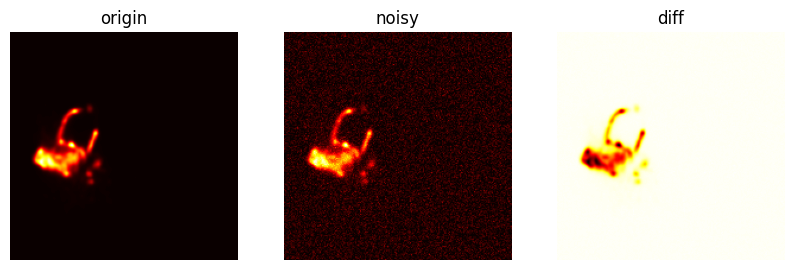

In [8]:
# demostrate
norm_slices = (slices_np - np.mean(slices_np)) / np.std(slices_np)
#norm_slices = (norm_slices - np.min(norm_slices)) / (np.max(norm_slices) - np.min(norm_slices))

print(f"norm_slices {norm_slices.shape} range:{(np.min(norm_slices), np.max(norm_slices))} mean:{np.mean(norm_slices)} std:{np.std(norm_slices)}")

#
rs = np.random.RandomState(seed=80)

#
clean_image = norm_slices[11, 38]
noisy_image = AdditivePoissonNoise(rs, lam=(0.9, 0.9), execution_probability=1.0)(norm_slices)[11, 38]

#
print(f"noisy_image {noisy_image.shape} range:{(np.min(noisy_image), np.max(noisy_image))} mean:{np.mean(noisy_image)} std:{np.std(noisy_image)}")
noisy_image = (noisy_image - np.min(noisy_image)) / (np.max(noisy_image) - np.min(noisy_image))
print(f"noisy_image {noisy_image.shape} range:{(np.min(noisy_image), np.max(noisy_image))} mean:{np.mean(noisy_image)} std:{np.std(noisy_image)}")

#
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
ax = axes.ravel()

ax[0].set_axis_off()
ax[0].imshow(clean_image, cmap='hot')
ax[0].set_title("origin")

ax[1].set_axis_off()
ax[1].imshow(noisy_image, cmap='hot')
ax[1].set_title("noisy")

ax[2].set_axis_off()
ax[2].imshow(noisy_image - clean_image, cmap='hot')
ax[2].set_title("diff")

In [9]:
norm_slices = (slices_np - np.mean(slices_np)) / np.std(slices_np)

min_val = np.min(norm_slices)
max_val = np.max(norm_slices)

#norm_slices = (norm_slices - np.min(norm_slices)) / (np.max(norm_slices) - np.min(norm_slices))


# nessary info for restored 
restore_info = {'mean': np.mean(slices_np).item(),
             'std': np.std(slices_np).item(),
             'min': min_val.item(),
             'max': max_val.item()}

print(restore_info)

poission_lams = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#poission_lams = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

# save gussian noise dataset
rs = np.random.RandomState(seed=80)
for lam in tqdm(poission_lams, desc='Processing'):
    noisy_slices = AdditivePoissonNoise(rs, lam=(lam, lam), execution_probability=1.0)(norm_slices)
    noisy_slices = (noisy_slices - np.min(noisy_slices)) / (np.max(noisy_slices)-np.min(noisy_slices))
    file_name = f"{os.path.basename(data_dir)}_poiss_{lam}"
    with h5py.File(f'./dataset/preprocessed/{file_name}.h5', 'w') as f:
        f.create_dataset('dataset', data=noisy_slices)
        f.create_dataset('restore_info', data=np.array(json.dumps(restore_info), dtype=h5py.string_dtype()))

{'mean': 201.12048776036573, 'std': 1412.4139804758772, 'min': -23.34168377224119, 'max': 23.05689405684542}


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

### Option 3 : Data Augmentation

In [ ]:
# 
patient_dir = "./dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM"

slices_np = load_4d_dicom(patient_dir)

print(f"Loaded...{slices_np.dtype} (shape:{slices_np.shape}; range:[{np.min(slices_np)},{np.max(slices_np)}]; mean:{np.mean(slices_np)}; std:{np.std(slices_np)})")

display_4d_image(slices_np)

#
norm_slices = (slices_np - np.mean(slices_np)) / np.std(slices_np)

In [ ]:
def process_augmentation(norm_slices, seeds):
    batch_all = []

    # Adding original data at 1st batch
    time_all = []
    for time_frame in slices_np:
        #aug = Standardize()(time_frame)
        #aug = Normalize(min_value=0, max_value=1)(aug)
        #aug = ToTensor(expand_dims=True)(aug)
        #aug = ToTensor(expand_dims=True)(time_frame)
        time_all.append(time_frame)

    #batch_all.append(torch.stack(time_all).unsqueeze(0))
    batch_all.append(np.array(time_all))

    # Apply data augmented
    for seed in tqdm(seeds, desc='Processing'):
        time_all = []
        for time_frame in slices_np:
            rs = np.random.RandomState(seed)
            """<<<start...apply 3D transform on each time frame>>>"""
            #aug = RandomRotate(rs, angle_spectrum=30, axes=[(1, 2)] ,mode='reflect')(time_frame) # this may cause artifact 
            aug = RandomRotate90(rs)(time_frame)
            aug = ElasticDeformation(rs, 3, alpha=20, sigma=3, execution_probability=1.0)(aug)
            #aug = Standardize()(aug)
            #aug = AdditiveGaussianNoise(rs, scale=(0.0, 1.0), execution_probability=1.0)(aug)
            #aug = AdditivePoissonNoise(rs, lam=(0, 1.0), execution_probability=1.0)(aug)
            #aug = Normalize(min_value=0, max_value=1)(aug)
            #aug = ToTensor(expand_dims=True)(aug)
            #print(f"aug : {aug.shape} range:[{aug.min()}, {aug.max()}] mean:{aug.mean()} std:{aug.std()}")
            time_all.append(aug)
            """<<<end....apply 3D transform on each time frame>>>"""
        #time_all = torch.stack(time_all).unsqueeze(0)
        #print(f"tima_all : {time_all.shape} range:[{time_all.min()}, {time_all.max()}] mean:{time_all.mean()} std:{time_all.std()}")
        #batch_all.append(time_all)
        batch_all.append(np.array(time_all))

    #batch_all = torch.cat(batch_all, dim=0)
    batch_all = np.array(batch_all)

    # save tensor as (N, T, C, Z, X, Y)
    
    return batch_all


#
task_name = f"{os.path.basename(patient_dir)}_augmented"
#task_name = "PT_20p 150_120_augmented_combined"
print(f"task_name: {task_name}")

#
batch_num = 10 # number of batch data augmented

# make augmentation reproducible
np.random.seed(0)
seeds = [np.random.randint(1, 1000) for _ in range(batch_num-1)]
print(f"seeds: {seeds}")

In [ ]:
batch_all = process_augmentation(slices_np, seeds)
#batch_all2 = process_transform(slices_np2, seeds)

#print(f"Process complete...{batch_all.dtype} (shape:{batch_all.shape}; range:[{batch_all.min()},{batch_all.max()}]; mean:{batch_all.mean()}; std:{batch_all.std()})")
print(f"Process complete...{batch_all.dtype} (shape:{batch_all.shape}; range:[{np.min(batch_all)},{np.max(batch_all)}]; mean:{np.mean(batch_all)}; std:{np.std(batch_all)})")

In [ ]:
# display augmented data
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
ax = axes.ravel()

#
time_idx = 11
depth_idx = 38
for i in range(9):
    ax[i].set_axis_off()
    #image = batch_all[i, time_idx, 0, depth_idx].numpy()
    image = batch_all[i, time_idx, depth_idx]
    ax[i].imshow(image, cmap='hot')
    print(f"{image.shape} dtype:{image.dtype} range:({np.min(image)}，{np.max(image)}) mean:{np.mean(image)} std:{np.std(image)}")

In [ ]:
# save raw data as h5
with h5py.File(f'./dataset/{task_name}.h5', 'w') as f:
    f.create_dataset('dataset', data=batch_all)


### test

convert to tensor and apply standarlize and normalization, then calculate PSNR and SSIM

In [ ]:
def process_data(data):
    tensor_data = torch.from_numpy(data).float()
    mean_val = tensor_data.mean()
    std_val = tensor_data.std()
    normalized_data = (tensor_data - mean_val) / std_val
    min_val = normalized_data.min()
    max_val = normalized_data.max()
    normalized_data = (normalized_data - min_val) / (max_val - min_val)
    
    return normalized_data, (mean_val, std_val, min_val, max_val)


def denormalize(normalized_data, mean_val, std_val, min_val, max_val):
    denormalied_data = normalized_data * (max_val - min_val) + min_val
    original_data = denormalied_data * std_val + mean_val
    return original_data
       
    

In [ ]:
# load noisy data
with h5py.File('./dataset/PT_20p 150_120 OSEM_augmented.h5', 'r') as f:
    noisy_data = f['dataset'][...]

#print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{noisy_data.min()},{noisy_data.max()}]; mean:{noisy_data.mean()}; std:{noisy_data.std()})")
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")


# load clean data 
with h5py.File('./dataset/PT_80p 250_50 OSEM_augmented.h5', 'r') as f:
    clean_data = f['dataset'][...]
    
#print(f"Clean data...{clean_data.dtype} (shape:{clean_data.shape}; range:[{clean_data.min()},{clean_data.max()}]; mean:{clean_data.mean()}; std:{clean_data.std()})")
print(f"Clean_data...{clean_data.dtype} (shape:{clean_data.shape}; range:[{np.min(clean_data)},{np.max(clean_data)}]; mean:{np.mean(clean_data)}); std:{np.std(clean_data)}")


In [ ]:
all_psnr, all_ssim = [], []
for clean_batch, noisy_batch in zip(clean_data, noisy_data):
    batch_psnr, batch_ssim = compute_psnr_ssim_from_4d_ndarray(clean_batch, noisy_batch)
    all_psnr.append(batch_psnr)
    all_ssim.append(batch_ssim)
    
all_psnr, all_ssim = np.array(all_psnr), np.array(all_ssim)

In [ ]:
psnr_mean = np.mean(all_psnr)
psnr_std = np.std(all_psnr)
psnr_argmax = np.unravel_index(np.argmax(all_psnr), all_psnr.shape)
psnr_argmin = np.unravel_index(np.argmin(all_psnr), all_psnr.shape)
ssim_mean = np.mean(all_ssim)
ssim_std = np.std(all_ssim)
ssim_argmax = np.unravel_index(np.argmax(all_ssim), all_ssim.shape)
ssim_argmin = np.unravel_index(np.argmin(all_ssim), all_ssim.shape)

print(f"all_psnr: mean: {psnr_mean}; std:{psnr_std}; argmin:{psnr_argmin}{all_psnr[psnr_argmin]}; argmax:{psnr_argmax}{all_psnr[psnr_argmax]}")
print(f"all_ssim: mean: {ssim_mean}; std:{ssim_std}; argmin:{ssim_argmin}{all_ssim[ssim_argmin]}; argmax:{ssim_argmax}{all_ssim[ssim_argmax]}")

In [ ]:
batch_idx = 0
plot_2d_data(all_psnr[batch_idx], "PSNR(db)")
plot_2d_data(all_ssim[batch_idx], "SSIM(%)")

In [ ]:
# convert ndarray into tensor, then normalized
norm_clean_tensor, (orignal_clean_mean, original_clean_std, original_clean_min, original_clean_max) = process_data(clean_data)
norm_noisy_tensor, (orignal_noisy_mean, original_noisy_std, original_noisy_min, original_noisy_max) = process_data(noisy_data)

print(f"norm_clean_tensor: {norm_clean_tensor.shape}\n mean: {orignal_clean_mean} -> {norm_clean_tensor.mean()}\n std: {original_clean_std} -> {norm_clean_tensor.std()}\n min: {original_clean_min} -> {norm_clean_tensor.min()}\n max: {original_clean_max} -> {norm_clean_tensor.max()}")
print(f"norm_noisy_tensor: {norm_noisy_tensor.shape}\n mean: {orignal_noisy_mean} -> {norm_noisy_tensor.mean()}\n std: {original_noisy_std} -> {norm_noisy_tensor.std()}\n min: {original_noisy_min} -> {norm_noisy_tensor.min()}\n max: {original_noisy_max} -> {norm_noisy_tensor.max()}")

In [ ]:
batch_idx = 0
display_4d_image(norm_clean_tensor[batch_idx].numpy())

In [ ]:
# denormalize data
clean_data_rev = denormalize(norm_clean_tensor, orignal_clean_mean, original_clean_std, original_clean_max, original_clean_min)
noisy_data_rev = denormalize(norm_noisy_tensor, orignal_noisy_mean, original_noisy_std, original_noisy_max, original_noisy_min)

print(f"clean_data_rev: {clean_data_rev.shape} mean:{clean_data_rev.mean()} std:{clean_data_rev.std()} min:{clean_data_rev.min()} max:{clean_data_rev.max()}")
print(f"noisy_data_rev: {noisy_data_rev.shape} mean:{noisy_data_rev.mean()} std:{noisy_data_rev.std()} min:{noisy_data_rev.min()} max:{noisy_data_rev.max()}")

In [ ]:
display_4d_image(clean_data_rev[batch_idx].numpy())